# Import libraries and data

In [1]:
# Import libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import geopandas
import numpy as np
import matplotlib as plt
import imageio
import os

%config InlineBackend.figure_format ='retina'
%matplotlib inline

In [2]:
# Import raw data
tornado = pd.read_csv("us_tornado_dataset_1950_2021.csv")
usa = geopandas.read_file('../ds_1300_notebooks/data/s_22mr22.shp')

# Process data

In [3]:
# Convert tornado data to correct format
gdf_tornado_start = geopandas.GeoDataFrame(tornado.drop(columns=['elon', 'elat']), geometry = geopandas.points_from_xy(tornado['slon'], tornado['slat']), crs="EPSG:4326")


In [4]:
# Remove Alaska, Hawaii, Puerto Rico, and Virgin Islands
usa = usa[usa['STATE']!='AK']
usa = usa[usa['STATE']!='HI']
usa = usa[usa['STATE']!='PR']
usa = usa[usa['STATE']!='VI']

gdf_tornado_start = gdf_tornado_start[gdf_tornado_start['st']!='AK']
gdf_tornado_start = gdf_tornado_start[gdf_tornado_start['st']!='HI']
gdf_tornado_start = gdf_tornado_start[gdf_tornado_start['st']!='PR']
gdf_tornado_start = gdf_tornado_start[gdf_tornado_start['st']!='VI']
gdf_tornado_start = gdf_tornado_start[gdf_tornado_start['slat']!=0]
gdf_tornado_start = gdf_tornado_start[gdf_tornado_start['slon']!=0]

In [5]:
# Create function to extract summary data by state in tornado df and merge with usa geo df
def extract_state_yr_summary(tor, geo, yr_start, yr_end):
    
    # Extract data in between start and end years (inclusive)
    tor_yr = tor[tor['yr'].between(yr_start, yr_end)]
    
    # Number of tornadoes by state
    num_tor = tor_yr.groupby(by='st').count()['yr']
    geo = pd.merge(geo, num_tor, left_on='STATE', right_on='st', how='inner')
    
    # Number of tornado injuries by state
    num_inj = tor_yr.groupby(by='st').sum()['inj']
    geo = pd.merge(geo, num_inj, left_on='STATE', right_on='st', how='inner')
    
    # Number of tornado fatalities by state
    num_fat = tor_yr.groupby(by='st').sum()['fat']
    geo = pd.merge(geo, num_fat, left_on='STATE', right_on='st', how='inner')
    
    # Average number of injuries/fatalities per tornado by state
    geo['av_inj'] = geo['inj'] / geo['yr']
    geo['av_fat'] = geo['fat'] / geo['yr']
    
    # Average magnitude of tornado by state
    num_mag = tor_yr.groupby(by='st').sum()['mag']
    geo = pd.merge(geo, num_mag, left_on='STATE', right_on='st', how='inner')
    geo['av_mag'] = geo['mag'] / geo['yr']
    
    # Rename columns
    geo.columns = ['STATE', 'NAME', 'FIPS', 'LON', 'LAT', 'geometry', 'num_tor', 'num_inj', 'num_fat', 'av_inj', 'av_fat', 'sum_mag', 'av_mag']
    
    # Return geo df
    return(geo)

In [6]:
tor_50 = extract_state_yr_summary(tornado, usa, 1950, 1959)
tor_60 = extract_state_yr_summary(tornado, usa, 1960, 1969)
tor_70 = extract_state_yr_summary(tornado, usa, 1970, 1979)
tor_80 = extract_state_yr_summary(tornado, usa, 1980, 1989)
tor_90 = extract_state_yr_summary(tornado, usa, 1990, 1999)
tor_00 = extract_state_yr_summary(tornado, usa, 2000, 2009)
tor_10 = extract_state_yr_summary(tornado, usa, 2010, 2019)

In [7]:
# Generate summary information per year
tor_per_year_count = pd.DataFrame(tornado.groupby(by='yr').count()['mag'])
tor_per_year_sum = pd.DataFrame(tornado.groupby(by='yr').sum()[['inj', 'fat']])
tor_per_year = pd.merge(tor_per_year_count, tor_per_year_sum, left_on='yr', right_on='yr', how='inner')
tor_per_year['av_mag'] = pd.DataFrame(tornado[tornado['mag']>0].groupby(by='yr').sum()['mag']) / pd.DataFrame(tornado[tornado['mag']>0].groupby(by='yr').count()['mag'])
tor_per_year['yr'] = tor_per_year.index

# Data analysis and visualization

## Map the number of tornadoes per decade

In [13]:
# Define function to find minimum and maximum for graph scales
def find_minmax3(col_of_int, df1, df2, df3):
    all_min = min(min(df1[col_of_int]), min(df2[col_of_int]), min(df3[col_of_int]))
    all_max = max(max(df1[col_of_int]), max(df2[col_of_int]), max(df3[col_of_int]))
    return(all_min, all_max)

def find_minmax7(col_of_int, df1, df2, df3, df4, df5, df6, df7):
    all_min = min(min(df1[col_of_int]), min(df2[col_of_int]), min(df3[col_of_int]), min(df4[col_of_int]), min(df5[col_of_int]), min(df6[col_of_int]), min(df7[col_of_int]))
    all_max = max(max(df1[col_of_int]), max(df2[col_of_int]), max(df3[col_of_int]), max(df4[col_of_int]), max(df5[col_of_int]), max(df6[col_of_int]), min(df7[col_of_int]))
    return(all_min, all_max)

# Find min/max for number of tornadoes
(num_tor_min,num_tor_max) = find_minmax3('num_tor', tor_90, tor_00, tor_10)
(num_tor_min_all,num_tor_max_all) = find_minmax7('num_tor', tor_50, tor_60, tor_70, tor_80, tor_90, tor_00, tor_10)

### Static graphs

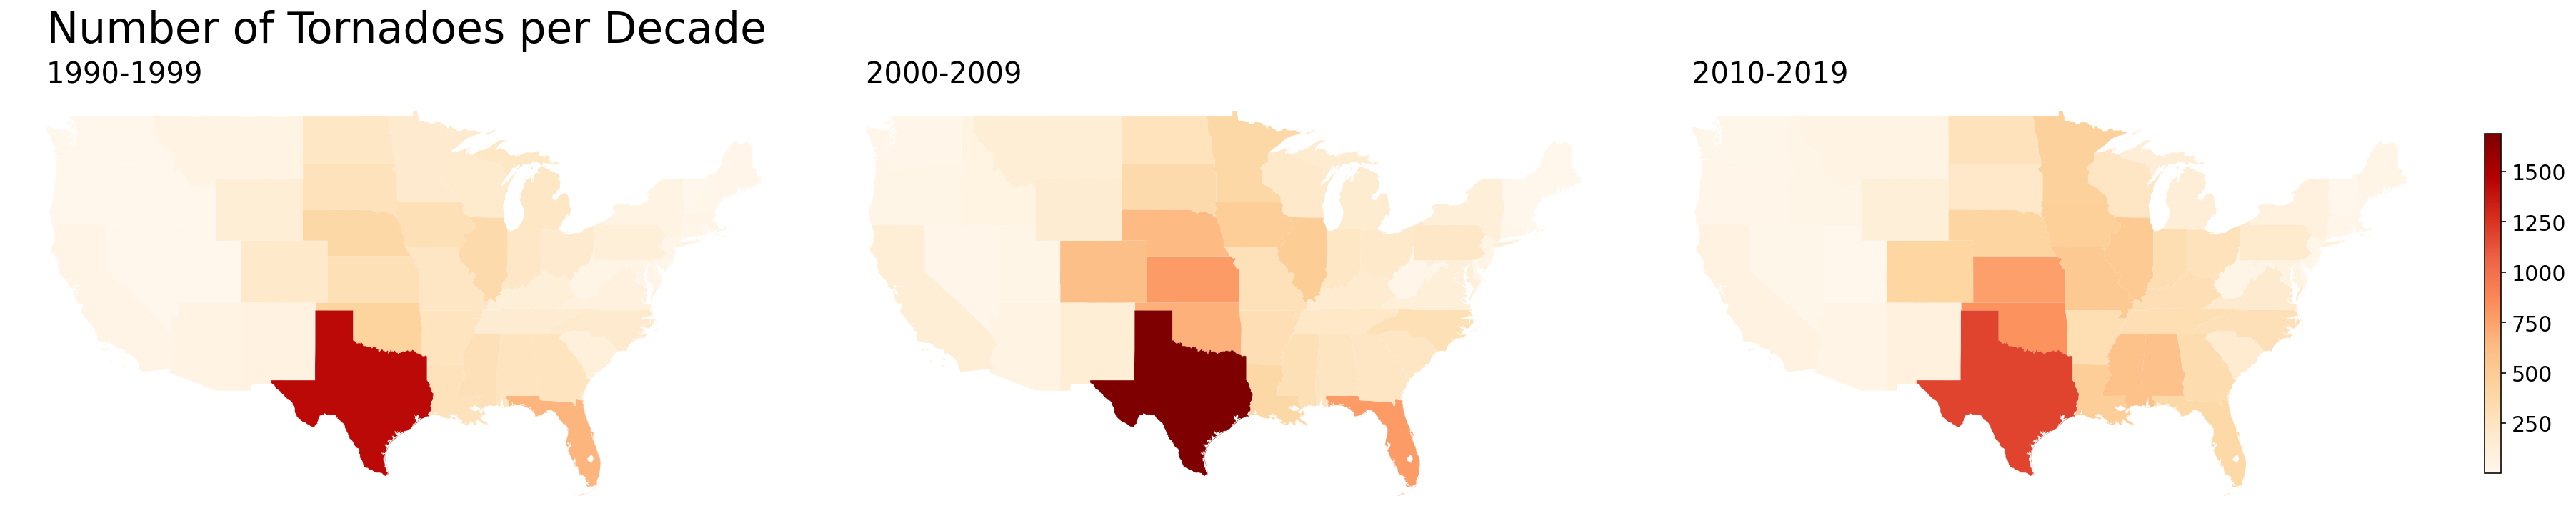

In [9]:
fig, (ax1, ax2, ax3) = plt.pyplot.subplots(nrows=1, ncols=3, figsize=(25, 5), layout='constrained')
color_scheme = 'OrRd'
fig.suptitle('  Number of Tornadoes per Decade', fontsize=30, x=0.153)
ax1 = tor_70.plot(ax=ax1, column='num_tor', vmin=num_tor_min, vmax=num_tor_max, legend=False, cmap=color_scheme)
ax1.set_title('    1990-1999',fontsize=20, loc='left')
ax1.set_axis_off();
ax2 = tor_90.plot(ax=ax2, column='num_tor', vmin=num_tor_min, vmax=num_tor_max, legend=False, cmap=color_scheme)
ax2.set_title('    2000-2009',fontsize=20, loc='left')
ax2.set_axis_off();
ax3 = tor_10.plot(ax=ax3, column='num_tor', vmin=num_tor_min, vmax=num_tor_max, legend=False, cmap=color_scheme, legend_kwds={'label': "Number of Tornados",'orientation': "horizontal"})
ax3.set_title('    2010-2019',fontsize=20, loc='left')
ax3.set_axis_off();

patch_col = ax2.collections[0]
cb = fig.colorbar(patch_col, shrink=0.8, ax=ax3, location='right', pad=0.05)
cb.ax.tick_params(labelsize=15) 
#cb.ax.set_title('Number of Tornadoes',fontsize=20)

plt.pyplot.savefig('tornado.map.counts.png')

In [58]:
gdf_tornado_start.head(3)

,yr,mo,dy,date,st,mag,inj,fat,slat,slon,len,wid,geometry
0,1950,1,3,1950-01-03,IL,3,3,0,39.10,-89.30,3.6,130,POINT (-89.30000 39.10000)
1,1950,1,3,1950-01-03,MO,3,3,0,38.77,-90.22,9.5,150,POINT (-90.22000 38.77000)
2,1950,1,3,1950-01-03,OH,1,1,0,40.88,-84.58,0.1,10,POINT (-84.58000 40.88000)


### Gif graph

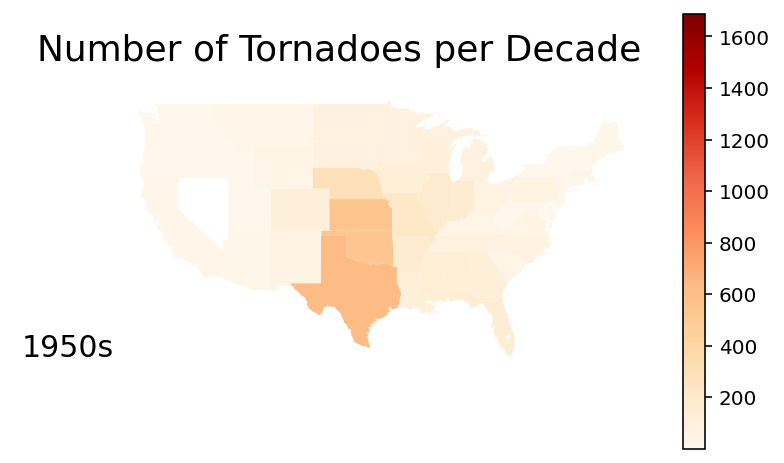

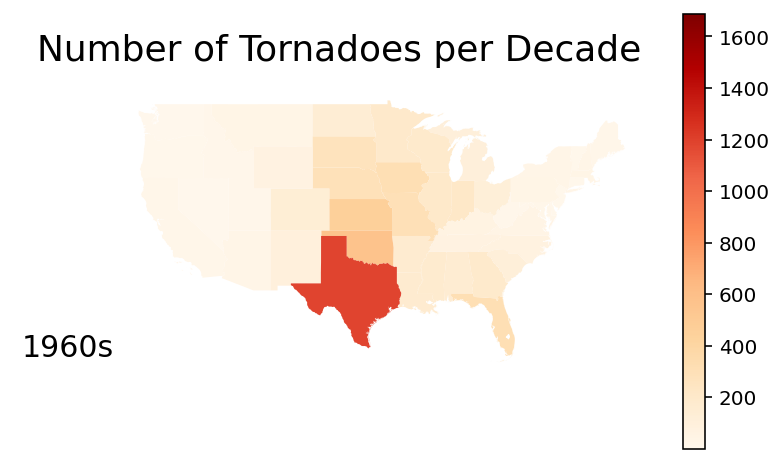

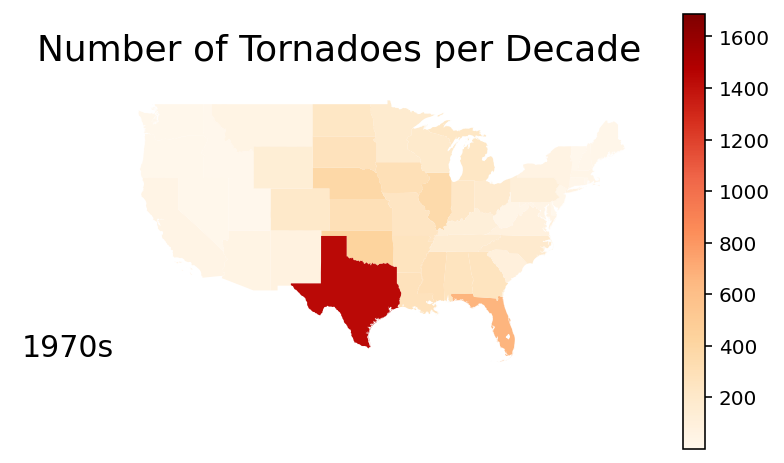

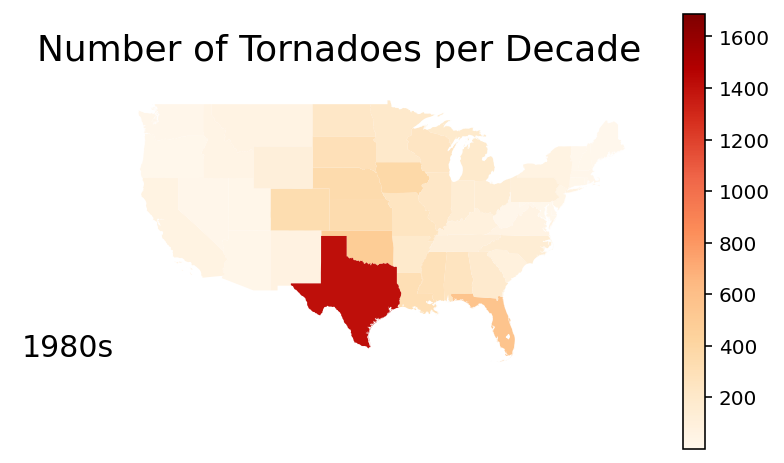

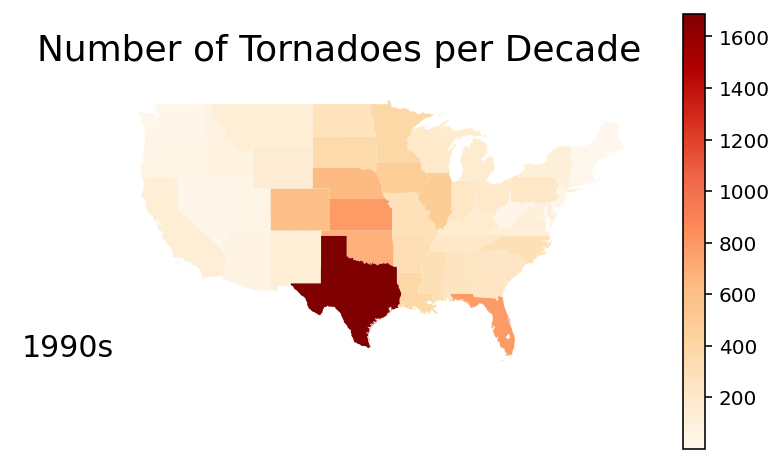

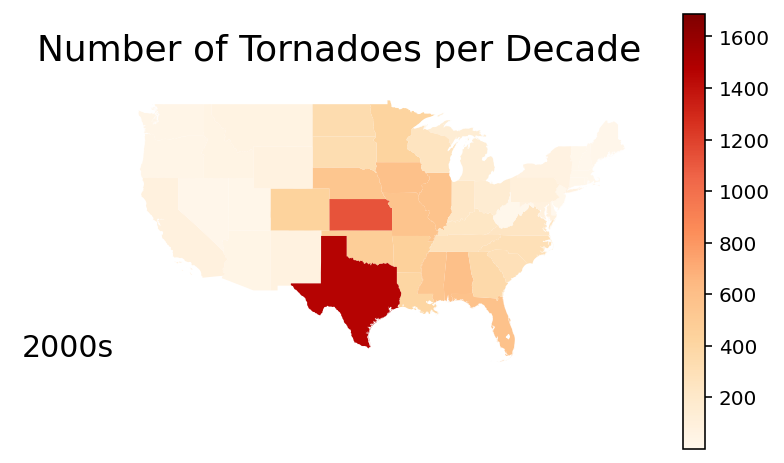

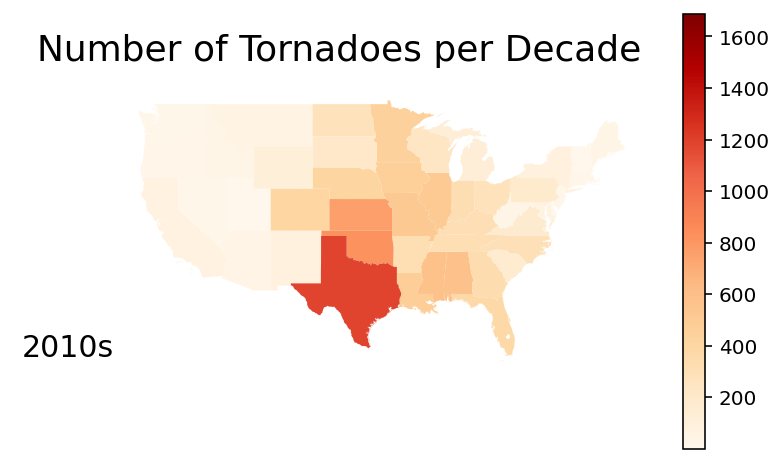

In [36]:
# Define decades
dec_start = [1950, 1960, 1970, 1980, 1990, 2000, 2010]

# Set save location
output_path = 'decade_density_maps'
file_names = []

# Create a for loop to create one map per decade
for dec in dec_start:
    
    # Extract decade summary data
    tor_dec_group = tornado[tornado['yr'].between(dec, dec+9)].groupby(by='st').count()['mag']
    gdf = pd.merge(usa, tor_dec_group, left_on='STATE', right_on='st', how='inner')
    
    # Create map
    fig = gdf.plot(column='mag', legend=True, cmap=color_scheme, vmin=num_tor_min_all, vmax=num_tor_max_all)
    
    # Remove axis of chart
    fig.axis('off')
    
    # Add a title and year label
    fig.set_title('  Number of Tornadoes per Decade', x=0.4, y=1.05, fontsize=18) 
    fig.annotate(str(dec) + 's', xy=(0.025, 0.225), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=15)
    
    # Save graph
    filepath = os.path.join(output_path, str(dec)+'num_tor.jpg')
    chart = fig.get_figure()
    chart.savefig(filepath, dpi=300)
    file_names.append(filepath)
    
# Save as a gif
with imageio.get_writer('num_tor_per_decade.gif', mode='I') as writer:
    for filename in file_names:
        for i in range(5):
            image = imageio.imread(filename)
            writer.append_data(image)

## Number of tornadoes per year

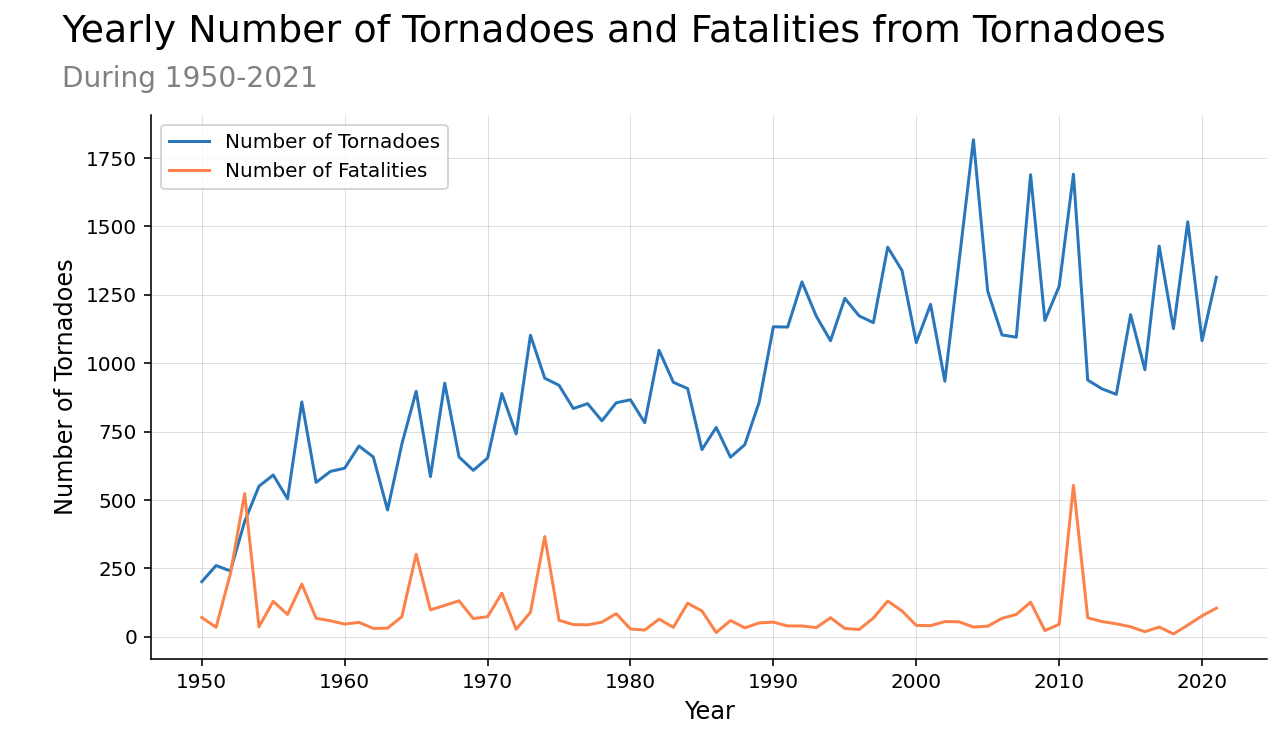

In [8]:
#plt.style.use('ggplot')
fig, ax = plt.pyplot.subplots(figsize=(10, 5))

# Plot
ax.plot(tor_per_year['yr'], tor_per_year['mag'], color='xkcd:bluish')
ax.plot(tor_per_year['yr'], tor_per_year['fat'], color='xkcd:orangish',)

# Titles and axis labels
fig.suptitle('    Yearly Number of Tornadoes and Fatalities from Tornadoes', fontsize=19, x=0.43, y=1.02)
ax.set_title('During 1950-2021', loc='left', fontsize=14, x=-0.08, y=1.03, color='gray')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Tornadoes', fontsize=12)

# Graph aesthetics
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

# Add legend
ax.legend(['Number of Tornadoes', 'Number of Fatalities'])
plt.pyplot.savefig('tornado.counts.fatalities.png', bbox_inches='tight', pad_inches=0.5)

## Number of tornadoes by month

In [9]:
# Create data frame to 
tor_per_mo = pd.DataFrame(range(1,13))
tor_per_mo.columns = ['mo']
tor_per_mo['month'] = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
tor_per_mo['num_tor'] = np.array(tornado.groupby(by='mo').count()['mag'])
tor_per_mo['ef0'] = np.array(tornado[tornado['mag']==0].groupby(by='mo').count()['yr'])
tor_per_mo['ef1'] = np.array(tornado[tornado['mag']==1].groupby(by='mo').count()['yr'])
tor_per_mo['ef2'] = np.array(tornado[tornado['mag']==2].groupby(by='mo').count()['yr'])
tor_per_mo['ef3'] = np.array(tornado[tornado['mag']==3].groupby(by='mo').count()['yr'])
tor_per_mo['ef4'] = np.array(tornado[tornado['mag']==4].groupby(by='mo').count()['yr'])
tor_per_mo = pd.merge(tor_per_mo, tornado[tornado['mag']==5].groupby(by='mo').count()['yr'], left_on='mo', right_on='mo', how='outer')
tor_per_mo.columns = ['mo', 'month', 'num_tor', 'ef0', 'ef1', 'ef2', 'ef3', 'ef4', 'ef5']
tor_per_mo = tor_per_mo.fillna(0)

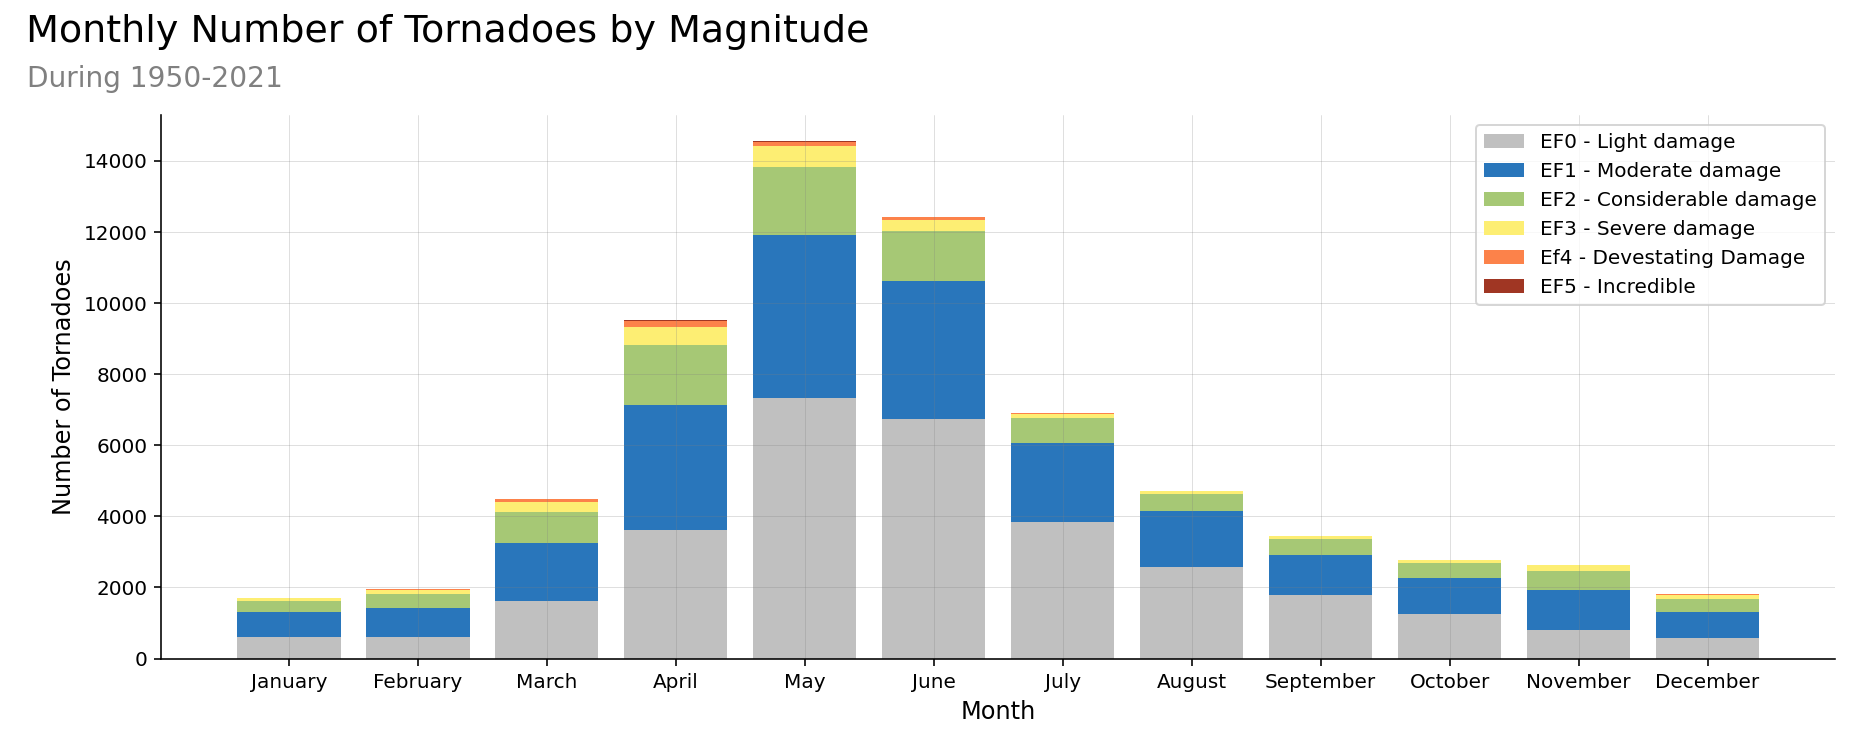

In [10]:
fig, ax = plt.pyplot.subplots(figsize=(15, 5))

# Create stacked bar chart for number of tornadoes
ax.bar(tor_per_mo['month'], tor_per_mo['ef0'], color='silver')
ax.bar(tor_per_mo['month'], tor_per_mo['ef1'], color='xkcd:bluish', bottom = tor_per_mo['ef0'])
ax.bar(tor_per_mo['month'], tor_per_mo['ef2'], color='xkcd:light moss green', bottom = (tor_per_mo['ef0']+tor_per_mo['ef1']))
ax.bar(tor_per_mo['month'], tor_per_mo['ef3'], color='xkcd:sandy yellow', bottom = (tor_per_mo['ef0']+tor_per_mo['ef1']+tor_per_mo['ef2']))
ax.bar(tor_per_mo['month'], tor_per_mo['ef4'], color='xkcd:orangish', bottom = (tor_per_mo['ef0']+tor_per_mo['ef1']+tor_per_mo['ef2']+tor_per_mo['ef3']))
ax.bar(tor_per_mo['month'], tor_per_mo['ef5'], color='xkcd:brick', bottom = (tor_per_mo['ef0']+tor_per_mo['ef1']+tor_per_mo['ef2']+tor_per_mo['ef3']+tor_per_mo['ef4']))

# Create legend
ax.legend(['EF0 - Light damage', 'EF1 - Moderate damage', 'EF2 - Considerable damage', 'EF3 - Severe damage', 'Ef4 - Devestating Damage', 'EF5 - Incredible'])

# Titles and axis labels
fig.suptitle(' Monthly Number of Tornadoes by Magnitude', fontsize=19, x=0.255, y=1.02)
ax.set_title('During 1950-2021', loc='left', fontsize=14, x=-0.08, y=1.03, color='gray')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Number of Tornadoes', fontsize=12)

# Graph aesthetics
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

plt.pyplot.savefig('tornado.counts.month.png', bbox_inches='tight', pad_inches=0.5)